# COVID mortality rates per country

This is a naive analysis of the published  mortality rates for the COVID 19 pandemic.

- pull the data from a csv on github
- turn it into a Pandas DataFrame
- do some filtering and a couple of plots

I believe that **everyone** should be able to do this.
Doing basic data analysis should be  like  what reading and writing
was at the beginning of the 20th century - a basic skill 
taught to every child at school.

The data is published [here](https://github.com/CSSEGISandData/COVID-19)

**2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE**

This is the data repository for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). 




In [2]:
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get the latest time series and save to disk

In [122]:
root_dir = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
fn = 'time_series_covid19_%s_global.csv'

for ss in ['deaths','confirmed']:
    r = requests.get(root_dir + fn%ss, allow_redirects=True)
    open('covid_%s.csv'%ss, 'wb').write(r.content)



# Parse them to a DataFrames

In [123]:
df = pd.read_csv('covid_deaths.csv')
dfc = pd.read_csv('covid_confirmed.csv')


In [186]:
dfc[140:145]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20
140,NaN,Jordan,31.2400,36.5100,0,0,0,0,0,0,...,154,172,212,235,246,259,268,274,278,299
141,NaN,Kazakhstan,48.0196,66.9237,0,0,0,0,0,0,...,72,81,111,150,228,284,302,343,380,435
142,NaN,Kenya,-0.0236,37.9062,0,0,0,0,0,0,...,25,28,31,31,38,42,50,59,81,110
143,NaN,"Korea, South",36.0000,128.0000,1,1,2,2,3,4,...,9037,9137,9241,9332,9478,9583,9661,9786,9887,9976
144,NaN,Kuwait,29.5000,47.7500,0,0,0,0,0,0,...,191,195,208,225,235,255,266,289,317,342


# Foyers

These are the hotspots for the pandemic
- I chose 300 because I can catch Germany like that

In [257]:
foyers = df[df[df.columns[-1]] > 300]
foyers.sort_values(by=foyers.columns[-2], 
                   ascending=False).iloc[:10,[1,-2]]

,Country/Region,4/11/20
225,US,20463
137,Italy,19468
201,Spain,16606
116,France,13832
223,United Kingdom,9875
133,Iran,4357
23,Belgium,3346
62,China,3219
120,Germany,2736
169,Netherlands,2643


## add the population data (for 2016)
https://datahub.io/JohnSnowLabs/population-figures-by-country

this is a pain as the 'pop' column is added with index -1
so I have to change all the code from iloc[4:] to iloc[4:-1]
to avoid this number polluting the daily numbers from WHO.


In [235]:
pop = pd.read_csv('population.csv')
pop.iloc[248,0] = 'US'
pop.iloc[109,0] = 'Iran'

pops = dict(list(pop.iloc[:,[0,-1] ].values))
ppp = {x: pops[x] for x in foyers.iloc[:,1].values}
df.loc[foyers.index,'pop'] =  [pops[x] for x in foyers.iloc[:,1]]

In [254]:
foyers['pop'].values

array([8.74735800e+06, 1.13481590e+07, 2.07652865e+08, 1.37866500e+09,
       1.63850680e+07, 6.68961090e+07, 8.26676850e+07, 2.61115456e+08,
       8.02774280e+07, 4.77309500e+06, 6.06005900e+07, 1.70184080e+07,
       1.03246110e+07, 4.64439590e+07, 9.90312200e+06, 8.37209800e+06,
       7.95124260e+07, 6.56372390e+07, 3.23127513e+08])

Text(0,0.5,'log(deaths)')

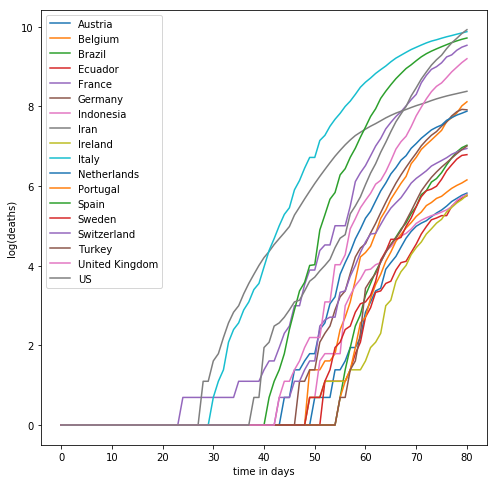

In [240]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

for x in foyers.index:
    if df.iloc[x]["Country/Region"] in ['China']: continue
    Y = np.log( df.iloc[x].values[4:-1].astype(np.float) + 1)
    ax.plot(np.arange(len(Y)),Y, label=df.iloc[x]["Country/Region"])

#ax.axis('equal')
leg = ax.legend()
plt.xlabel('time in days')
plt.ylabel('log(deaths)')

so the graph shows log(deaths) 

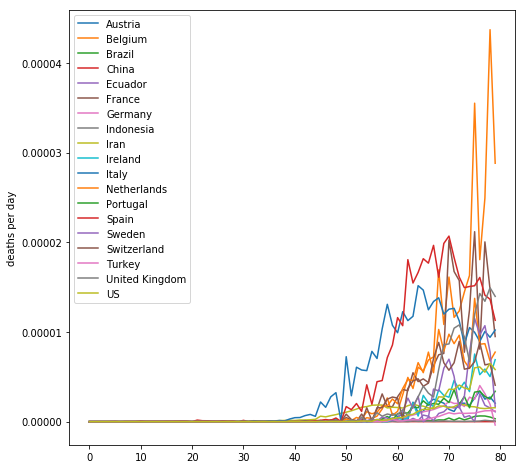

In [241]:
sss = df[ df[df.columns[-1]] > 2000]
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
for k in sss.index:
    x = df.iloc[k,4:-1].values
    cn = df.iloc[k,1]
    #x[1:] - x[:-1]
    ax.plot(np.diff(x)/ppp[cn], 
            label=df.iloc[k]["Country/Region"])
    
leg = ax.legend()
plt.ylabel('deaths per day')
plt.savefig('dd.png')

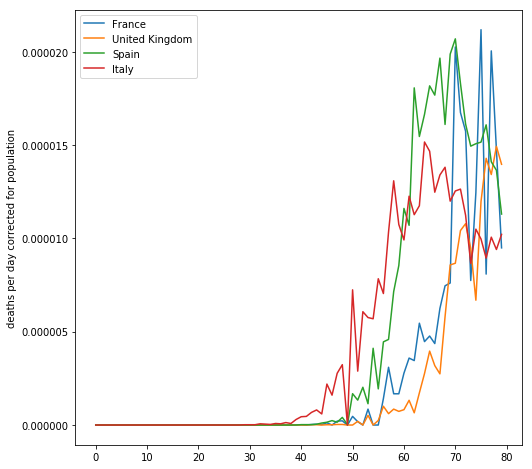

In [261]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
for k in [116,223,201,137]:
    x = df.iloc[k,4:-1].values
    Y = np.diff(x)/df.iloc[k,-1]
    #X = [(k + 6) % 7 for k in range(len(Y))]
    ax.plot(Y,label=df.iloc[k]["Country/Region"])

plt.ylabel('deaths per day corrected for population')
leg = ax.legend()

## per day deaths

In [245]:
day_by_day = np.diff(df.iloc[:,4:-1], axis=1)
for k in [116,120,201,137,223,225]:
    print(df.iloc[k,1].ljust(15), day_by_day[k,-7:] )

France          [ 518  833 1417  541 1341  987  635]
Germany         [140 226 206 333 258 160 -31]
Spain           [694 700 704 747 655 634 525]
Italy           [525 636 604 542 610 570 619]
United Kingdom  [621 439 786 938 881 980 917]
US              [1212 1164 1939 1973 1783 2108 1877]


In [246]:
tt = sorted([( max(np.diff(df.iloc[k][4:-1])), k) 
                for k in foyers.index], 
                    key=lambda x: -x[0]/ppp[df.iloc[x[1],1]])
for x,y in tt:
    cn = df.iloc[y,1]
    print(cn.ljust(15),  str(x).ljust(5), '%.2f'%(x/ppp[cn]*ppp['France']) )

Belgium         496   2923.86
France          1417  1417.00
Spain           961   1384.19
Italy           919   1014.47
United Kingdom  980   998.80
Netherlands     234   919.81
Sweden          114   770.08
Switzerland     75    599.28
Ireland         36    504.55
US              2108  436.41
Germany         333   269.47
Portugal        37    239.73
Austria         30    229.43
Ecuador         51    208.22
Iran            158   131.66
Turkey          98    82.45
Brazil          133   42.85
China           242   11.74
Indonesia       40    10.25


# Linear regression

If a quantity is growing/decaying exponentially 
then by taking logs we should get a straignt line....

We can calculate the best fit straight line 
to the data by doing linear regression.



In [248]:
from scipy import stats


def lin_reg(mdf, indices, window = 10):
    X = []
    for c in indices:
        Y = mdf.iloc[c].values[ -window:-1].astype(np.float)
        # apply a cut off
        Y = np.log(Y[Y > 100])
        vv = stats.linregress(np.arange(len(Y)), Y)
        X.append((c, np.exp(vv.slope), np.exp(vv.intercept).astype(int) ))
    return X

## these are the results

In [249]:
ww = 10
cc = countries = [x for x in foyers.index if x != 62]

X = list(zip(* lin_reg(df,cc,window=ww)))
Z = list(zip(* lin_reg(dfc,cc,window=ww)))

X[2] = Z[1]
X[0] = [dfc.iloc[x]["Country/Region"] for x in X[0]]
dff = pd.DataFrame({'country' : X[0], 'deaths': X[1], 'confirmed': X[2]})
dff

,country,deaths,confirmed
0,Austria,1.093379,1.024320
1,Belgium,1.148209,1.068991
2,Brazil,1.159401,1.119418
3,Ecuador,1.101574,1.086189
4,France,1.099890,1.094565
5,Germany,1.110015,1.045011
6,Indonesia,1.079883,1.088544
7,Iran,1.034911,1.037839
8,Ireland,1.132421,1.086020
9,Italy,1.035449,1.030579


# Calculate days till herd immunity achieved

- The population is roughly $67 \times 10^6$.
- dfc holds the stats for confirmed cases
- dff holds the growth rates

So we need to do something like
$$\frac{1}{ \text{growth rate}} \times
\log \left( .6 \times \frac{\text{Population}}{\text{# infected total}} 
\right)
$$

When I think about it whether it's .6 or .4 makes hardly any difference
because we are taking logs and the difference is less than 1/2.

In [71]:
np.log( dff.iloc[2,2])   + np.log( dff.iloc[2,1]) ,  dfc.iloc[116, -1]

(0.25645576941207504, 112950)

In [290]:
np.log(20)/np.log(1.11)

28.705747735340562

In [72]:
np.log(.6*67*10**6/ 10/ dfc.iloc[116, -1]) /.13,  dfc.iloc[116, -1]

(27.47763029768503, 112950)

Text(0,0.5,'confirmed cases growth rate')

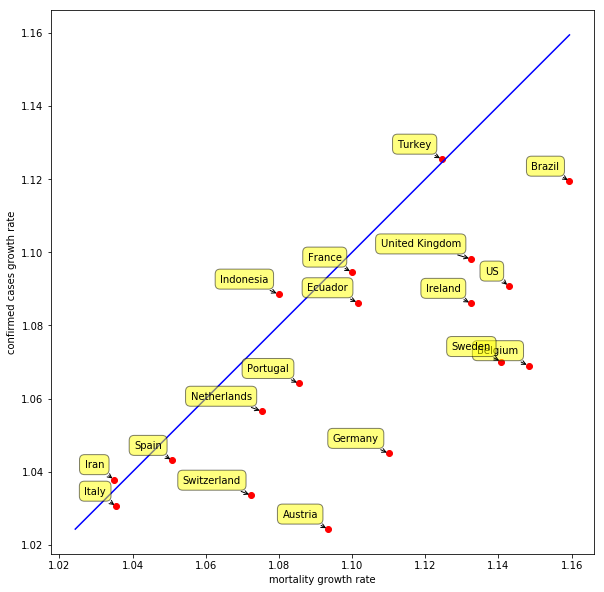

In [250]:
labels = dfc.iloc[cc]["Country/Region"]

fig, ax = plt.subplots()
fig.set_size_inches(10,10)
for label, x, y in zip(dff['country'], dff['deaths'],dff['confirmed']):
    ax.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

ax.plot(dff['deaths'],dff['confirmed'],'ro')
ax.set_aspect('equal')

bx = [min(dff['confirmed']), max(dff['deaths'])]
plt.plot(bx,bx,'b')
plt.xlabel('mortality growth rate')
plt.ylabel('confirmed cases growth rate')

TypeError: 'float' object is not iterable

## Calculate rolling averages for some countries for the last 36 days


this was something somebody asked me to do for another problem
but it's a standard way of smoothing data.

In [71]:
df.iloc[cc,-1]

23       513
116     3024
120      645
133     2757
137    11591
169      864
201     7716
206      359
223     1408
225     2978
Name: 3/30/20, dtype: int64

In [255]:
start = -30
data = [df.iloc[nn , start:-1].rolling(5).sum() for nn in cc ]
filtered_data = [ x[x>5000].values for x in data]

## should really pad the filtered_data so that it's for the same period

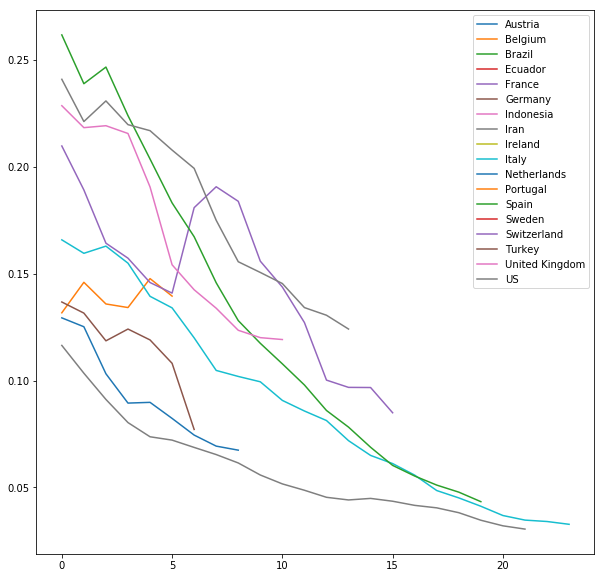

In [256]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
for x,label in zip(filtered_data, df.iloc[cc]["Country/Region"]):
    ax.plot( np.diff(np.log(x)), label=label)

leg = ax.legend();

# rolling sums for math

In [87]:
filtered_data[1]

array([  119.,   148.,   208.,   266.,   309.,   409.,   478.,   535.,
         687.,   989.,  1403.,  1929.,  2546.,  3196.,  3965.,  4987.,
        6122.,  7336.,  8611.,  9939., 11467.])

In [103]:
np.log(.6*67*10**6/52128)/np.log(1.11)

63.701792506762544

In [96]:
dfc.iloc[116,-1]

52128

In [152]:
np.exp(np.log(1250)/23)

1.3634783972515458

In [183]:
'Reidemeister'.lower()[:10]

'reidemeist'

/home/gregmcshane/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [207]:
foyers['pop']

16     8.747358e+06
23     1.134816e+07
28     2.076529e+08
62     1.378665e+09
97     1.638507e+07
116    6.689611e+07
120    8.266768e+07
132    2.611155e+08
133    8.027743e+07
135    4.773095e+06
137    6.060059e+07
169    1.701841e+07
184    1.032461e+07
201    4.644396e+07
205    9.903122e+06
206    8.372098e+06
213    7.951243e+07
223    6.563724e+07
225    3.231275e+08
Name: pop, dtype: float64